In [1]:
import pandas as pd
import geopandas
import contextily as ctx # pip install contextily==1.0rc2
%matplotlib inline

## Load data

In [2]:
racks = geopandas.read_file("../data/cityracks-shp/cityracks.shp")

In [7]:
racks.head(5)

,SITE_ID,Borough,CD,BBL,House__,Street_Nam,Street_On,From_Stree,To_Street,Side_of_St,Asset_Type,Latitude,Longitude,geometry
0,18941.0,Brooklyn,None,None,15.0,LAFAYETTE AV,LAFAYETTE AV,FLATBUSH AV,ASHLAND PL,None,Bike Rack,40.686790,-73.978510,POINT (-73.97851 40.68679)
1,18940.0,Brooklyn,None,None,15.0,LAFAYETTE AV,LAFAYETTE AV,FLATBUSH AV,ASHLAND PL,None,Bike Rack,40.686790,-73.978510,POINT (-73.97851 40.68679)
2,18939.0,Brooklyn,None,None,15.0,LAFAYETTE AV,LAFAYETTE AV,FLATBUSH AV,ASHLAND PL,None,Bike Rack,40.686790,-73.978510,POINT (-73.97851 40.68679)
3,18658.0,Brooklyn,None,None,24.0,4 AV,4 AV,ATLANTIC AV,PACIFIC ST,None,Bike Rack,40.684012,-73.978633,POINT (-73.978633 40.684012)
4,18995.0,Brooklyn,None,None,65.0,LAFAYETTE AV,LAFAYETTE AV,S ELLIOTT PL,FORT GREENE PL,None,Bike Rack,40.687072,-73.975805,POINT (-73.97580499999999 40.687072)


## Plot bike racks

In [8]:
ax = racks.to_crs(epsg=3857).plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

ctx.add_basemap(ax)

RuntimeError: b'latitude or longitude exceeded limits'

Oh no!  Looks like some of our bike rack data is bad.  Here's one rack with invalid data.

In [9]:
racks.iloc[12598]

SITE_ID                                                   11267
Borough                                               Manhattan
CD                                                         None
BBL                                                        None
House__                                                     488
Street_Nam                                              YORK AV
Street_On                                               YORK AV
From_Stree                                                 None
To_Street                                                  None
Side_of_St                                                 None
Asset_Type                                            Bike Rack
Latitude                                                      0
Longitude                                                     0
geometry      POINT (-1.797693134862316e+308 -1.797693134862...
Name: 12598, dtype: object

## Remove racks with invalid lat/long

In [10]:
location_outlier_mask = (racks.Latitude == 0) | (racks.Longitude == 0)
outliers = racks[location_outlier_mask]
outliers.head(5)

,SITE_ID,Borough,CD,BBL,House__,Street_Nam,Street_On,From_Stree,To_Street,Side_of_St,Asset_Type,Latitude,Longitude,geometry
12588,18985.0,Manhattan,None,None,132.0,ALBANY ST,ALBANY ST,None,None,None,Bike Rack,0.0,0.0,POINT (-1.797693134862316e+308 -1.797693134862...
12591,11253.0,Manhattan,None,None,2937.0,AMSTERDAM AV,AMSTERDAM AV,118,None,None,Bike Rack,0.0,0.0,POINT (-1.797693134862316e+308 -1.797693134862...
12592,11252.0,Manhattan,None,None,2937.0,AMSTERDAM AV,AMSTERDAM AV,118,None,None,Bike Rack,0.0,0.0,POINT (-1.797693134862316e+308 -1.797693134862...
12593,10248.0,Manhattan,None,None,31.0,ST JAMES ST,ST JAMES ST,None,None,None,Bike Rack,0.0,0.0,POINT (-1.797693134862316e+308 -1.797693134862...
12598,11267.0,Manhattan,None,None,488.0,YORK AV,YORK AV,None,None,None,Bike Rack,0.0,0.0,POINT (-1.797693134862316e+308 -1.797693134862...


In [11]:
cleaned = racks[~location_outlier_mask]
cleaned.head()

,SITE_ID,Borough,CD,BBL,House__,Street_Nam,Street_On,From_Stree,To_Street,Side_of_St,Asset_Type,Latitude,Longitude,geometry
0,18941.0,Brooklyn,None,None,15.0,LAFAYETTE AV,LAFAYETTE AV,FLATBUSH AV,ASHLAND PL,None,Bike Rack,40.686790,-73.978510,POINT (-73.97851 40.68679)
1,18940.0,Brooklyn,None,None,15.0,LAFAYETTE AV,LAFAYETTE AV,FLATBUSH AV,ASHLAND PL,None,Bike Rack,40.686790,-73.978510,POINT (-73.97851 40.68679)
2,18939.0,Brooklyn,None,None,15.0,LAFAYETTE AV,LAFAYETTE AV,FLATBUSH AV,ASHLAND PL,None,Bike Rack,40.686790,-73.978510,POINT (-73.97851 40.68679)
3,18658.0,Brooklyn,None,None,24.0,4 AV,4 AV,ATLANTIC AV,PACIFIC ST,None,Bike Rack,40.684012,-73.978633,POINT (-73.978633 40.684012)
4,18995.0,Brooklyn,None,None,65.0,LAFAYETTE AV,LAFAYETTE AV,S ELLIOTT PL,FORT GREENE PL,None,Bike Rack,40.687072,-73.975805,POINT (-73.97580499999999 40.687072)


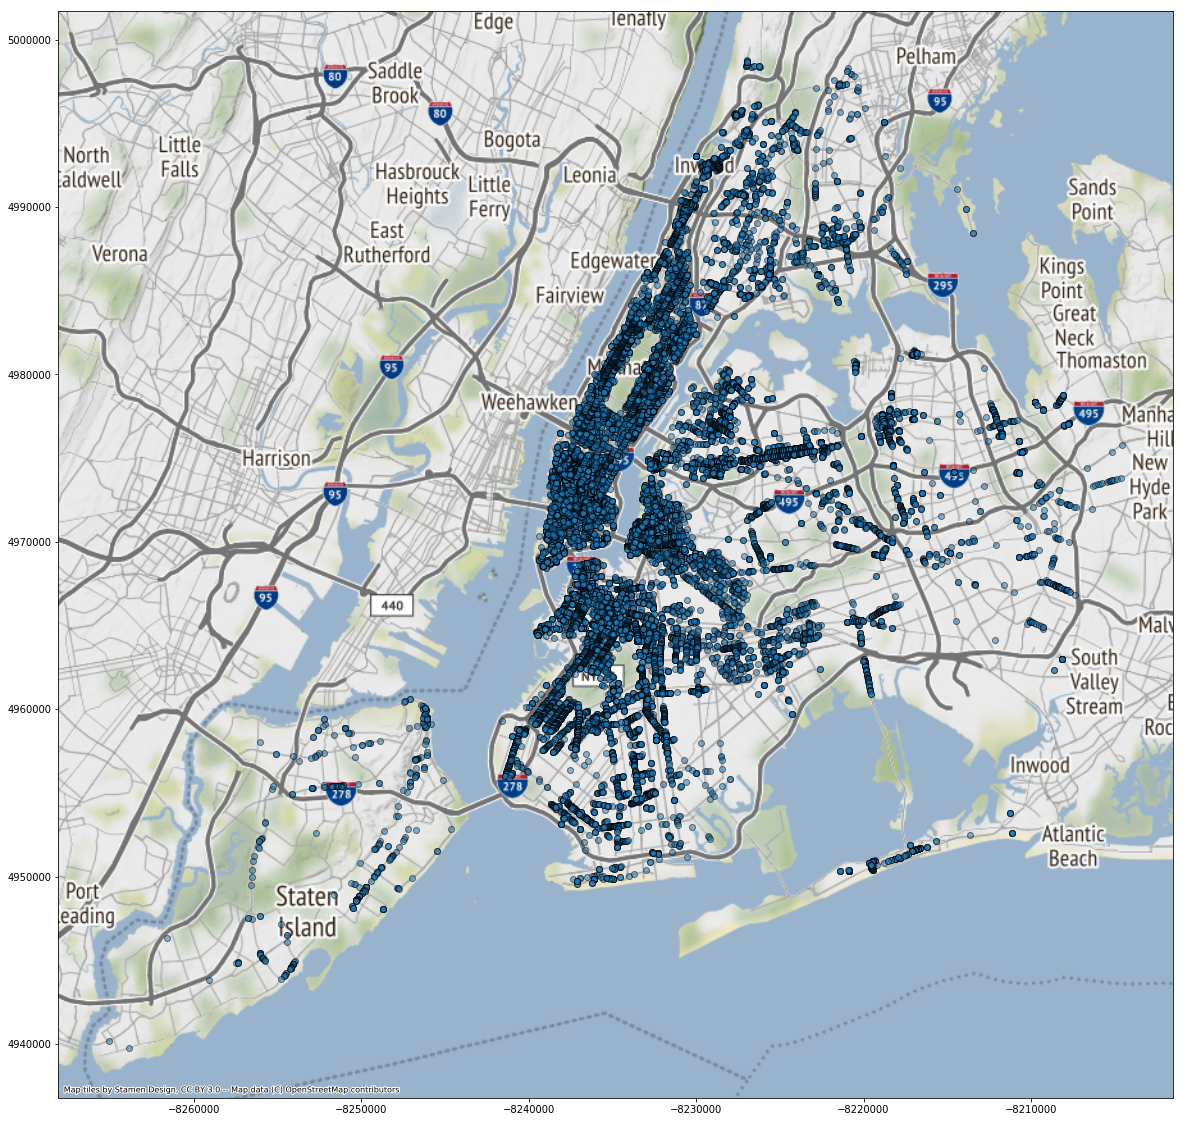

In [12]:
ax = cleaned.to_crs(epsg=3857).plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

ctx.add_basemap(ax)

## Write data to postgres

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://')

In [ ]:
sql_df = cleaned[['SITE_ID', 'House__', 'Street_Nam', 'Latitude', 'Longitude']]
sql_df = sql_df.rename(columns={
    'SITE_ID': 'site_id', 
    'House__': 'house_number',
    'Street_Nam': 'street_name',
    'Latitude': 'latitude',
    'Longitude': 'longitude'})

sql_df['site_id'] = sql_df['site_id'].apply(lambda r: str(int(r)))
sql_df['house_number'] = sql_df['house_number'].apply(lambda r: str(int(r)))

sql_df

In [ ]:
from sqlalchemy.types import String
sql_df.to_sql('racks', engine, if_exists='append', index=False, dtype={
    'site_id': String,
    'house_number': String,
    'street_name' : String,
    'latitude': String,
    'longitude': String
})